# Capstone Project (DS-GA 1001)

### Libraries

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA

import missingno as msno
import warnings

# Significance tests
from scipy.stats import mannwhitneyu

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
#pd.set_option('display.max_rows')
#pd.reset_option(“max_columns”)

# Imports function from GitHub
!curl -Os https://raw.githubusercontent.com/jgeorge313/DS_GA_1001_Capstone/main/Contributors/Helper_Functions.py
%run Helper_Functions.py

In [24]:
ds_dataset = pd.read_csv('https://raw.githubusercontent.com/jgeorge313/DS_GA_1001_Capstone/main/Levels_Fyi_Salary_Data.csv')
F1000_dataset = pd.read_csv('https://raw.githubusercontent.com/jgeorge313/DS_GA_1001_Capstone/main/Fortune_1000.csv')

ds_dataset['company'] = ds_dataset['company'].str.lower()
F1000_dataset['company'] = F1000_dataset['company'].str.lower()
raw_df = pd.merge(ds_dataset, F1000_dataset, how='left', on='company')
raw_df.head()

,timestamp,company,level,title,totalyearlycompensation,location,yearsofexperience,yearsatcompany,tag,basesalary,...,state,newcomer,ceo_founder,ceo_woman,profitable,prev_rank,CEO,Website,Ticker,Market Cap
0,6/7/2017 11:33:27,oracle,L3,Product Manager,127000,"Redwood City, CA",1.5,1.5,NaN,107000.0,...,CA,no,no,yes,yes,81.0,Safra A. Catz,https://www.oracle.com,ORCL,170158
1,6/10/2017 17:11:29,ebay,SE 2,Software Engineer,100000,"San Francisco, CA",5.0,3.0,NaN,0.0,...,CA,no,no,no,yes,295.0,Jamie Iannone,https://www.ebay.com,EBAY,23930.2
2,6/11/2017 14:53:57,amazon,L7,Product Manager,310000,"Seattle, WA",8.0,0.0,NaN,155000.0,...,WA,no,yes,no,yes,5.0,Jeffrey P. Bezos,https://www.amazon.com,AMZN,1637405
3,6/17/2017 0:23:14,apple,M1,Software Engineering Manager,372000,"Sunnyvale, CA",7.0,5.0,NaN,157000.0,...,CA,no,no,no,yes,3.0,Timothy D. Cook,https://www.apple.com,AAPL,2221176
4,6/20/2017 10:58:51,microsoft,60,Software Engineer,157000,"Mountain View, CA",5.0,3.0,NaN,0.0,...,WA,no,no,no,yes,26.0,Satya Nadella,https://www.microsoft.com,MSFT,1696122


In [25]:
raw_df = match_industry(raw_df) # Fills in sector 

#Rounds the number of years of experience (reduces number of categories)
raw_df.loc[:,'yearsofexperience'] = np.round(raw_df.loc[:,'yearsofexperience'])
raw_df.loc[:,'yearsatcompany'] = np.round(raw_df.loc[:,'yearsatcompany'])

#Drop users that had a higher value for yearsatcompany than yearsofexperience
raw_df.drop(raw_df[(raw_df.loc[:,'yearsatcompany'] - raw_df.loc[:,'yearsofexperience']) > 0].index.to_list(), inplace=True)

#Fill in missing values for dmaid
raw_df['dmaid'].fillna(raw_df['dmaid'].median(), inplace=True)

#Changes the category names of education to fit into plot
raw_df['Education'].replace({"Master's Degree": "Master's", "Bachelor's Degree": "Bachelor's"}, inplace=True)

#Add region, faang, year columns and cleans the tag and sector columns
raw_df = extract_state(raw_df)
raw_df = extract_year(raw_df)
raw_df = extract_tag(raw_df)
raw_df = faang(raw_df)
raw_df = match_industry(raw_df)

# Deletes wrong input in gender
raw_df.drop(raw_df[raw_df['gender'] == 'Title: Senior Software Engineer'].index, inplace=True)

In [26]:
df = raw_df[['company', 'title', 'totalyearlycompensation', 'location', 'yearsofexperience', 'yearsatcompany', 
             'gender', 'Education', 'Race', 'sector', 'region', 'faang', 'dmaid', 'tag', 'year']]

### General plots

<AxesSubplot:>

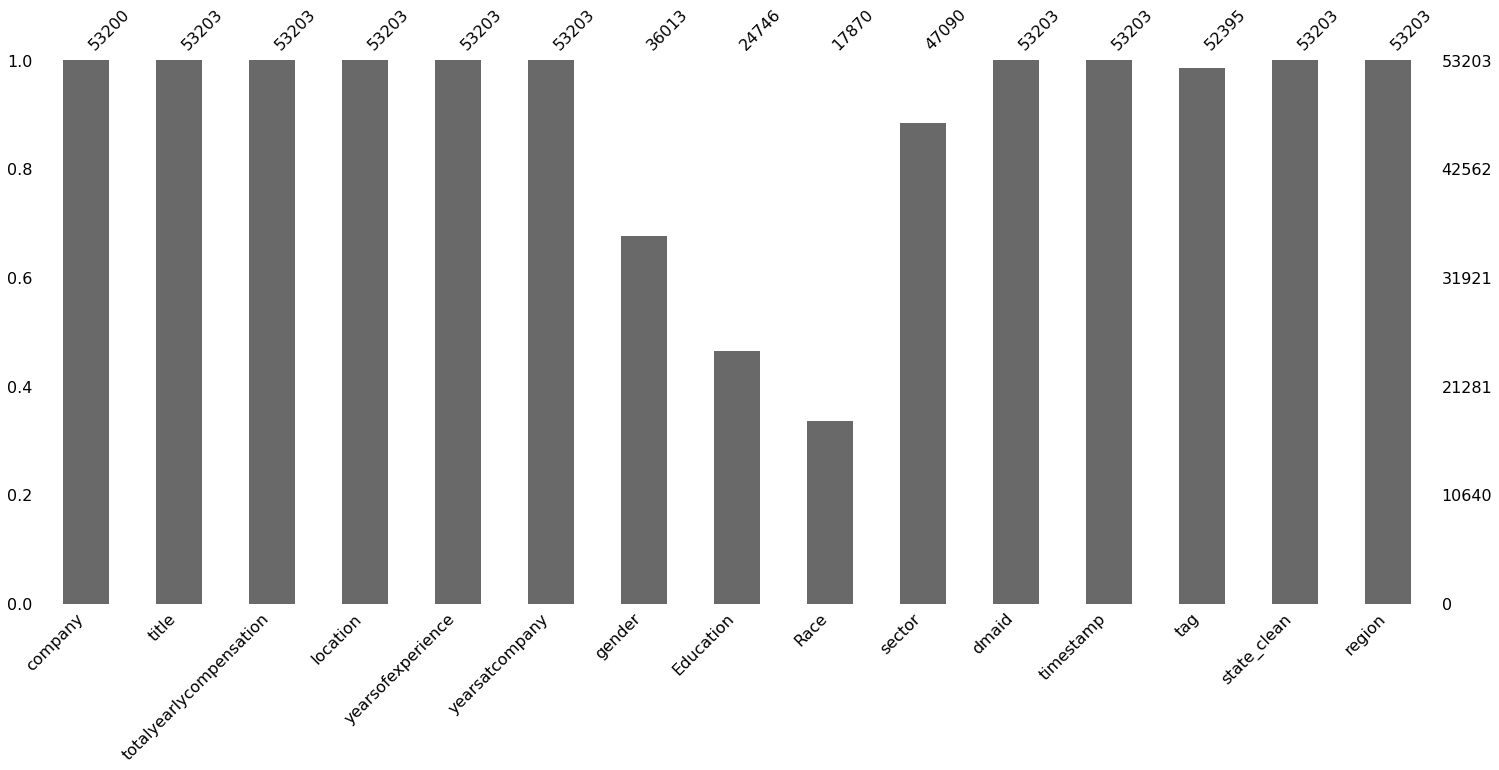

In [136]:
msno.bar(df)

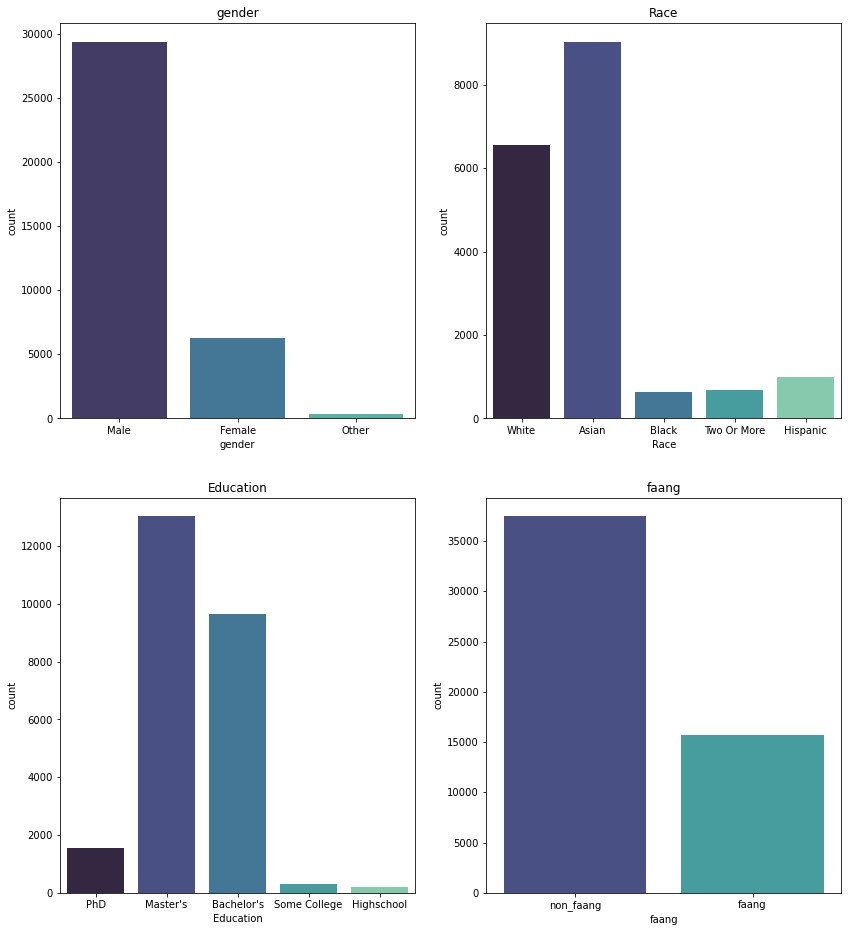

In [279]:
categorical_features = ['gender', 'Race', 'Education', 'faang']

plot_features(df, categorical_features, is_categorical=True)

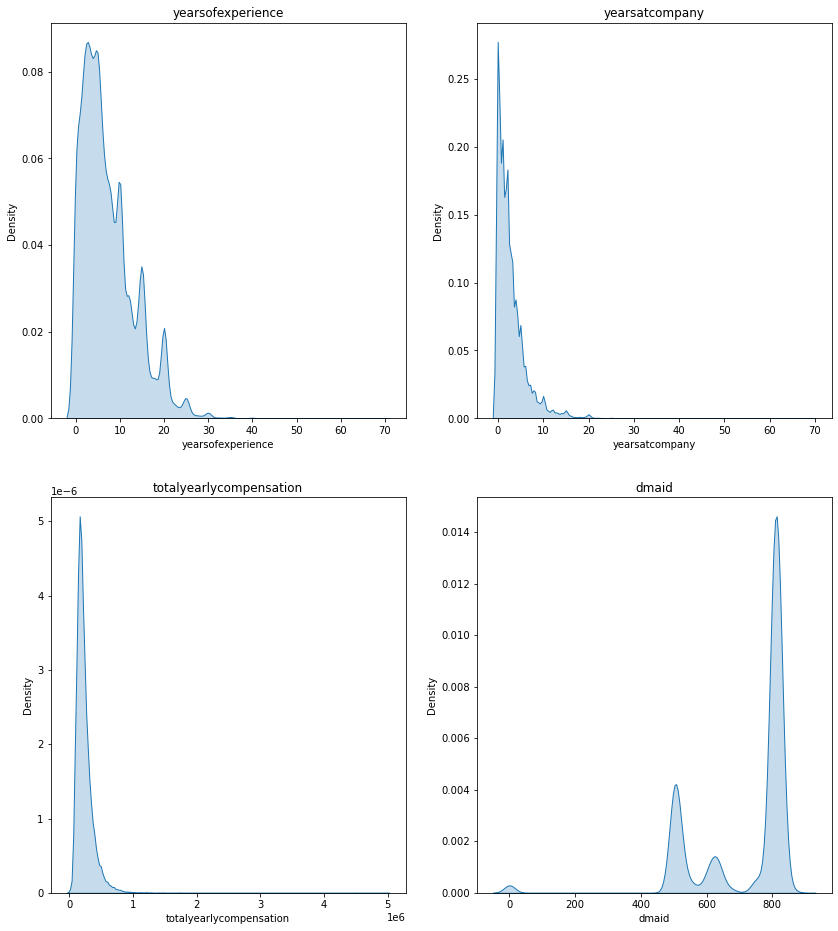

In [242]:
continuous_features = ['yearsofexperience', 'yearsatcompany', 'totalyearlycompensation', 'dmaid']

plot_features(df, continuous_features, is_categorical=False)

### Hypothesis Testing

#### Hypothesis 1 (When controlling for experience, do people with high vs. low experience years at current company make more?)

$H_0$: People that have worked longer in a company earn equal salaries than people that have not worked as long in that same company.

$H_1$: People that have worked longer in a company earn significantly different salaries than people that have not worked as long in that same company.<br>

**Controlling for 10 to 15 years of experience*

In [68]:
test_input1 = hypothesis_data1(df, 'yearsofexperience', 'yearsatcompany', 'totalyearlycompensation', [5, 10, 15])

In [69]:
for key in test_input1.keys():
    test = mannwhitneyu(test_input1[key][0], test_input1[key][1], alternative='two-sided') #Runs a Mann Whitney U-test
    if test.pvalue < 0.05:
        print('{} years of experience: \nWe reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))
    else:
        print('{} years of experience: \nWe fail to reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))

0-5 years of experience: 
We reject the Null Hypothesis (p-value = 8.20617760212296e-09)

5-10 years of experience: 
We reject the Null Hypothesis (p-value = 7.819016176467319e-25)

10-15 years of experience: 
We reject the Null Hypothesis (p-value = 6.141006318835416e-14)

15-69.0 years of experience: 
We reject the Null Hypothesis (p-value = 4.414279693710039e-21)



In [199]:
for key in test_input1.keys():
    print('{} years of experience: \nlow experience: ${}, high experience: ${}\n'.format(key, int(test_input1[key][0].median()), int(test_input1[key][1].median())))

0-5 years of experience: 
low experience: $163000, high experience: $165000

5-10 years of experience: 
low experience: $220000, high experience: $204000

10-15 years of experience: 
low experience: $260000, high experience: $241000

15-69.0 years of experience: 
low experience: $306000, high experience: $280000



#### Hypothesis 2 (When controlling for experience, do people that work at FAANG earn higher salaries than people that don't?)

$H_0$: People that work at FAANG earn the same salary than other non-FAANG tech workers. <br>
$H_1$: People that work at FAANG earn a significantly different salary than other non-FAANG tech workers.<br>

**Controlling for 10 to 15 years of experience*

In [123]:
test_input2 = hypothesis_data2(df, 'yearsofexperience', 'sector', 'company', 'totalyearlycompensation', [5, 10, 15])

In [124]:
for key in test_input2.keys():
    test = mannwhitneyu(test_input2[key][0], test_input2[key][1], alternative='two-sided') #Runs a Mann Whitney U-test
    if test.pvalue < 0.05:
        print('{} years of experience: \nWe reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))
    else:
        print('{} years of experience: \nWe fail to reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))

0-5 years of experience: 
We reject the Null Hypothesis (p-value = 6.436652489992963e-185)

5-10 years of experience: 
We reject the Null Hypothesis (p-value = 2.146955162653161e-124)

10-15 years of experience: 
We reject the Null Hypothesis (p-value = 8.998371825758678e-88)

15-69.0 years of experience: 
We reject the Null Hypothesis (p-value = 1.3318807798551037e-107)



In [200]:
for key in test_input2.keys():
    print('{} years of experience: \nfaang: ${}, non-faang: ${}\n'.format(key, int(test_input2[key][0].median()), int(test_input2[key][1].median())))

0-5 years of experience: 
faang: $193000, non-faang: $169000

5-10 years of experience: 
faang: $255000, non-faang: $215000

10-15 years of experience: 
faang: $310000, non-faang: $250000

15-69.0 years of experience: 
faang: $375000, non-faang: $290000



#### Hypothesis 3 (When controlling for experience, do men and women earn significantly different pay?)

$H_0$: The salaries of men and women are not statistically different. <br>
$H_1$: The salaries of men and women are statistically different. .<br>

**Controlling for years of experience*

In [238]:
test_input3 = hypothesis_data3(df, [5, 10, 15])

In [239]:
for key in test_input3.keys():
    test = mannwhitneyu(test_input3[key][0], test_input3[key][1], alternative='two-sided') #Runs a Mann Whitney U-test
    if test.pvalue < 0.05:
        print('{} years of experience: \nWe reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))
    else:
        print('{} years of experience: \nWe fail to reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))

0-5 years of experience: 
We reject the Null Hypothesis (p-value = 2.180897419119702e-05)

5-10 years of experience: 
We reject the Null Hypothesis (p-value = 1.0718224045009119e-15)

10-15 years of experience: 
We reject the Null Hypothesis (p-value = 2.745490804996118e-15)



In [240]:
for key in test_input3.keys():
    print('{} years of experience: \nFemale: ${}, Male: ${}\n'.format(key, int(pd.Series(test_input3[key][0]).median()), int(pd.Series(test_input3[key][1]).median())))

0-5 years of experience: 
Female: $165000, Male: $169000

5-10 years of experience: 
Female: $200000, Male: $219000

10-15 years of experience: 
Female: $228000, Male: $256000



#### Hypothesis 4 (When controlling for experience, do people with different education levels earn significally different salaries?)

$H_0$: People with different education levels do not earn statistically different salaries. <br>
$H_1$: People with different education levels earn statistically different salaries.<br>
*Controlling for years of experience

In [129]:
test_input4 = hypothesis_data4(df, [5, 10, 15])

In [167]:
#combos = [[0,1],[0,2],[0,3],[1,2],[1,3],[2,3]]
combos = [[0,1],[1,2],[2,3]]
names = ['high school', 'bachelors', 'masters', 'Phd']

for key in test_input4.keys():
    for combo in combos:
    
        test = mannwhitneyu(test_input4[key][combo[0]], test_input4[key][combo[1]], alternative='two-sided') #Runs a Mann Whitney U-test
        if test.pvalue < 0.05:
            print('{} years of experience: ({}-{}) \nWe reject the Null Hypothesis (p-value = {})  Median salary: {} {}\n'.format(key, names[combo[0]], names[combo[1]], test.pvalue, round(np.median(test_input4[key][combo[0]])), round(np.median(test_input4[key][combo[1]]))))
        else:
            print('{} years of experience: ({}-{})\nWe fail to reject the Null Hypothesis (p-value = {}) Median salary: {} {}\n'.format(key, names[combo[0]], names[combo[1]], test.pvalue, np.median(test_input4[key][combo[0]]), round(np.median(test_input4[key][combo[1]]))))

0-5 years of experience: (high school-bachelors)
We fail to reject the Null Hypothesis (p-value = 0.8369201834310984) Median salary: 143500.0 146000

0-5 years of experience: (bachelors-masters) 
We reject the Null Hypothesis (p-value = 2.0070135830594647e-101)  Median salary: 146000 172000

0-5 years of experience: (masters-Phd) 
We reject the Null Hypothesis (p-value = 4.005478789189562e-71)  Median salary: 172000 220000

5-10 years of experience: (high school-bachelors)
We fail to reject the Null Hypothesis (p-value = 0.7385430957420708) Median salary: 194000.0 192000

5-10 years of experience: (bachelors-masters) 
We reject the Null Hypothesis (p-value = 2.744612535994459e-18)  Median salary: 192000 213000

5-10 years of experience: (masters-Phd) 
We reject the Null Hypothesis (p-value = 1.6410622329664713e-47)  Median salary: 213000 285000

10-15 years of experience: (high school-bachelors) 
We reject the Null Hypothesis (p-value = 0.028788564893051198)  Median salary: 278000 2260

#### Hypothesis 5 (When controlling for experience, do people living in different regions have significantly different salaries?)

$H_0$: People living in different regions do not earn statistically different salaries. <br>
$H_1$: People living in different regions earn statistically different salaries.<br>
*Controlling for years of experience

In [293]:
test_input5 = hypothesis_data5(df, [5, 10, 15])

In [294]:
years_exp = ['0-5', '5-10', '10-15', '15-100']
for key in test_input5.keys(): 
    value_1 = test_input5[key]
    for key2 in test_input5.keys():
        value_2 = test_input5[key2]
        if (key[0] != key2[0]) & (key[1] == key2[1]):
            test = mannwhitneyu(test_input5[key], test_input5[key2], alternative='two-sided') 
            #if test.pvalue < 0.001:
            #    print('{} years of experience ({}-{})\nWe reject the Null Hypothesis (p-value = {})\n'.format(years_exp[int(key[1])], key[0], key2[0] ,test.pvalue))
            #else: 
            #    print('{} years of experience ({}-{})\nWe fail to reject the Null Hypothesis (p-value = {})\n'.format(years_exp[int(key[1])], key[0] ,key2[0], test.pvalue))

#### Hypothesis 6 (When controlling for experience, do people working in Finance and Technology sectors earn statistically different salaries?)

$H_0$: People working in the finance and technology industry do not earn statistically different salaries. <br>
$H_1$: People working in the finance and technology industry earn statistically different salaries.<br>

**Controlling for years of experience*

In [232]:
test_input6_tech, test_input6_fin = hypothesis_data6(df)

In [233]:
for key in test_input6_tech.keys():
        test = mannwhitneyu(test_input6_tech[key], test_input6_fin[key], alternative='two-sided') 
        if test.pvalue < 0.05: 
            print('{} years of experience: We reject the Null Hypothesis (p-value = {})'.format(key, test.pvalue)) 
            print('Tech median: {}, Finance median: {}\n'.format(np.median(np.array(test_input6_tech[key])), np.median(np.array(test_input6_fin[key]))))
        else: 
            print('{} years of experience: We fail to reject the Null Hypothesis (p-value = {})\n'.format(key, test.pvalue))
            print('Tech median: {}, Finance median: {}\n'.format(np.median(np.array(test_input6_tech[key])), np.median(np.array(test_input6_fin[key]))))


0-5 years of experience: We reject the Null Hypothesis (p-value = 0.0)
Tech median: 178000.0, Finance median: 119000.0

5-10 years of experience: We reject the Null Hypothesis (p-value = 1.3951343397385799e-122)
Tech median: 233000.0, Finance median: 155000.0

10+ years of experience: We reject the Null Hypothesis (p-value = 2.9806484314698306e-78)
Tech median: 302000.0, Finance median: 200000.0



### Preprocessing

#### One-Hot encoding + Standardize

In [56]:
df = df.dropna().reset_index(drop=True)

In [57]:
#Remove outliers
df.drop(np.where(df['totalyearlycompensation'] > 1000000)[0].tolist(), inplace=True)

In [58]:
features = df[['title', 'gender', 'Education', 'Race', 'sector', 'yearsofexperience', 'yearsatcompany', 'region', 
                      'faang', 'dmaid', 'year', 'tag']]
target = df['totalyearlycompensation']

In [59]:
onehot_df = features[['yearsofexperience', 'yearsatcompany', 'dmaid']].copy()

scaler = StandardScaler()
target = pd.DataFrame(scaler.fit_transform(target.array.reshape(-1,1)), columns=['totalyearlycompensation'])
onehot_df = pd.DataFrame(scaler.fit_transform(onehot_df), columns = onehot_df.columns)

cat_features = ['title', 'gender', 'Education', 'Race', 'sector', 'region', 'faang', 'tag', 'year']
for column in cat_features: 
    onehot_df = pd.concat([onehot_df, pd.get_dummies(features[column].reset_index(drop=True), drop_first=True)], axis=1)

#### Linear Regression

In [31]:
kf = KFold(n_splits=10, shuffle=True, random_state=101)
kf.get_n_splits(onehot_df)

train_error, test_error, R_squared = [], [], []

for train_index, test_index in kf.split(onehot_df):
    X_train, X_test = onehot_df.iloc[train_index], onehot_df.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    linreg = LinearRegression().fit(X_train, y_train)
    
    y_train_pred = linreg.predict(X_train)
    y_test_pred = linreg.predict(X_test) 
    
    train_error.append(mean_squared_error(y_train, y_train_pred))
    test_error.append(mean_squared_error(y_test, y_test_pred))
    R_squared.append(linreg.score(X_test, y_test))

print('Training MSE for this Linear Regression model: {}'.format(round(np.mean(train_error), 3)))
print('Testing MSE for this Linear Regression model: {}\n'.format(round(np.mean(test_error), 3)))
print('R^2: {}\n'.format(round(np.mean(R_squared), 3)))

Training MSE for this Linear Regression model: 0.54
Testing MSE for this Linear Regression model: 0.545

R^2: 0.454



#### Lasso Regression

In [32]:
x_train, x_test, y_train, y_test = train_test_split(
onehot_df, target, test_size=0.1, random_state=101)

cva = RepeatedKFold(n_splits=10,n_repeats = 3, random_state=101)

model = LassoCV(alphas=np.arange(0.001,1,0.001), cv=cva,n_jobs=-1)
model.fit(x_train,y_train)
print(model.alpha_)

0.001


In [33]:
kf = KFold(n_splits=10, shuffle=True, random_state=101)
kf.get_n_splits(onehot_df)

train_error, test_error, R_squared = [], [], []

for train_index, test_index in kf.split(onehot_df):
    X_train, X_test = onehot_df.iloc[train_index], onehot_df.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]

    lasso = Lasso(alpha=0.001)
    lasso.fit(X_train, y_train)

    train_ypred = lasso.predict(X_train)

    test_ypred = lasso.predict(X_test)

    train_error.append(mean_squared_error(train_ypred,y_train))

    test_error.append(mean_squared_error(test_ypred,y_test))

    R_squared.append(lasso.score(X_test, y_test))

print('Training MSE for this Lasso Regression model: {}'.format(round(np.mean(train_error), 3)))
print('Testing MSE for this Lasso Regression model: {}\n'.format(round(np.mean(test_error), 3)))
print('R^2: {}\n'.format(round(np.mean(R_squared), 3)))

lasso_df = pd.DataFrame(lasso.coef_, onehot_df.columns, columns=['regression_coef'])

Training MSE for this Lasso Regression model: 0.544
Testing MSE for this Lasso Regression model: 0.548

R^2: 0.452



In [34]:
display(lasso_df.sort_values(by = 'regression_coef'))

,regression_coef
non_faang,-0.394754
Recruiter,-0.321586
Aerospace & Defense,-0.257850
Health Care,-0.116523
Telecommunications,-0.096189
...,...
yearsofexperience,0.477225
PhD,0.487537
Transportation,0.495050
Media,0.538055


#### XG Boost (using subset of data)

In [65]:
# Subset of columns with hight Lasso coefficient
onehot_df = onehot_df[lasso_df[lasso_df['regression_coef'] != 0].index]

kf = KFold(n_splits=10, shuffle=True, random_state=101)
kf.get_n_splits(onehot_df)

train_error, test_error, R_squared = [], [], []

for train_index, test_index in kf.split(onehot_df):
    X_train, X_test = onehot_df.iloc[train_index], onehot_df.iloc[test_index]
    y_train, y_test = target.iloc[train_index], target.iloc[test_index]
    
    clf_xgb = xgb.XGBRegressor(random_state=101, max_depth=3, n_estimators=500, eta=0.35).fit(X_train, y_train)
    
    y_train_pred = clf_xgb.predict(X_train)
    y_test_pred = clf_xgb.predict(X_test) 
    
    train_error.append(mean_squared_error(y_train, y_train_pred))
    test_error.append(mean_squared_error(y_test, y_test_pred))
    R_squared.append(clf_xgb.score(X_test, y_test))

print('Training MSE for this XGBoost Regression model: {}'.format(round(np.mean(train_error), 3)))
print('Testing MSE for this Linear Regression model: {}\n'.format(round(np.mean(test_error), 3)))  
print('R^2: {}\n'.format(round(np.mean(R_squared), 3)))

Training MSE for this XGBoost Regression model: 0.327
Testing MSE for this Linear Regression model: 0.461

R^2: 0.538

